In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
from scipy.optimize import curve_fit

In [2]:
from traceTwoStateSimulation import tracePackageSimulation
from telegraph import exponential
from pol_signal import pol_signal
from loopFunction import SnailPromoterMs2Loops,loopInterpolate,tailUpMs2
from autocorrelationDataProcessing import tracePackageAutocorrelation

from autocorrelationAnalyticInference import fitAutocorrelationFunction

In [31]:
# define all needed parameters for simulation and fitting #
from loopFunction import DespondsMs2Loops

stepsize = 3.8            # time between observations, seconds
tPol=6;                 # polII loading time
k_elong=25;             # Elongation rate
sizePol = tPol * k_elong     # Footprint, in basepairs, of polII

k_on = 0.0137
k_off = 0.0139
duration = 615   # seconds
num = 100           # number of traces in our simulated dataset

loop_function = SnailPromoterMs2Loops().loop_function

In [32]:
# simulated trace package
tracePackage = tracePackageSimulation(num, k_on, k_off, duration, stepsize, loop_function, k_elong, tPol)

In [33]:
# Now let's read in the CRISPR data
table = Table.read('carola-data/carola-control-trace-1.csv')

In [34]:
len(table)

554

In [35]:
np.zeros(int(642 // 3.8));

In [36]:
datatracelist = []
for name in table.colnames:
    datatracelist.append((np.asarray(table[name])).astype(float))

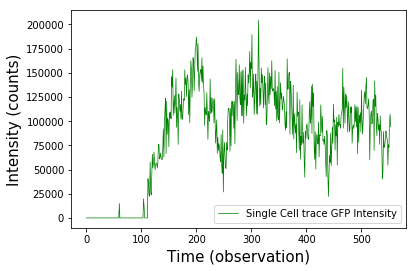

In [37]:
plt.plot(datatracelist[20], 'g', linewidth=0.7, label = 'Single Cell trace GFP Intensity')
plt.xlabel('Time (observation)', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.legend(loc='best')

In [38]:
type(datatracelist[15])

numpy.ndarray

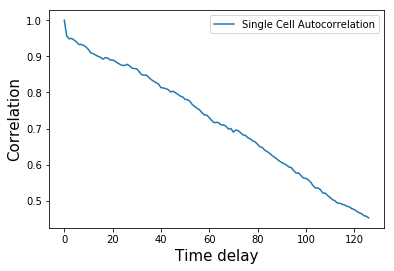

In [39]:
examp = np.correlate(datatracelist[14][300:], datatracelist[14][300:], 'same')
plt.plot(examp[np.argmax(examp):]/np.max(examp), label= 'Single Cell Autocorrelation')
plt.ylabel('Correlation', fontsize=15)
plt.xlabel('Time delay', fontsize=15)
plt.legend(loc='best')
plt.show()

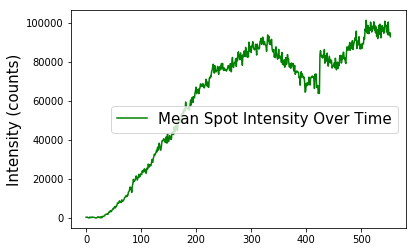

In [40]:
plt.plot(np.mean((datatracelist), axis=0), color='g', label='Mean Spot Intensity Over Time')
plt.legend(loc='best', fontsize=15)
plt.ylabel('Intensity (counts)', fontsize=15)
plt.show()

In [41]:
len(datatracelist[1])

554

In [42]:
# define start and stop indeces
start_index = 250
stop_index = -1

In [43]:
autopackage = tracePackageAutocorrelation(datatracelist, loop_function, start_index, stop_index)

In [44]:
t = np.arange(len(autopackage.tracelist[1][1:])) * stepsize

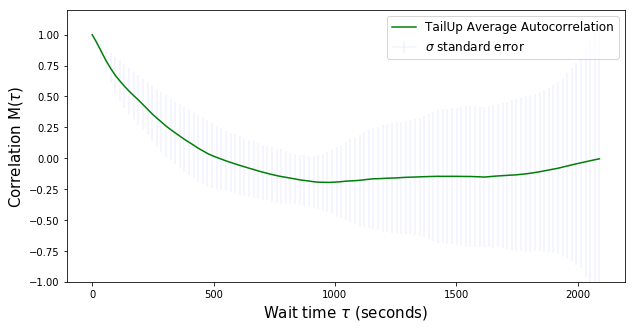

111


In [45]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)
tplot = t[::5]
autoav = autopackage.autoav[::5]
autostd = autopackage.auto_err[::5]
avgflors = autopackage.avgflors[::5]

ax.plot(tplot, autoav, color = 'g', label = "TailUp Average Autocorrelation")
ax.errorbar(x=tplot, y=autoav, yerr=(autostd, autostd), ecolor='b', alpha=0.05, label = r'$\sigma$ standard error')  
ax.legend(loc='best', fontsize='large')
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'Correlation M($\tau$)', fontsize=15)
ax.set_ylim(-1, 1.2)
plt.show()

print(len(autoav))

In [46]:
# fit for pon in a SIMPLE way
def fitPon(autopackage, loop_function):
    avg_flors = autopackage.avgflors
    pon = np.mean(avg_flors / np.sum(loop_function)) 
    pon_std = np.std(avg_flors/ np.sum(loop_function)) 

    return pon,pon_std

In [47]:
pon,pon_std = fitPon(autopackage, loop_function)
print(pon)

0.34244341209871487


In [48]:
fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)

Pon                       =  0.3424434120987148
k_on + k_off              =  0.004404480614373271 s^-1
k_on                      =  0.0015082853701086265
k_off                     =  0.002896195244264644
t_polII_block             =  6 seconds
characteristic timescale  =  227.04152601709058 seconds
covariance                =  1.0314787767650652e-08


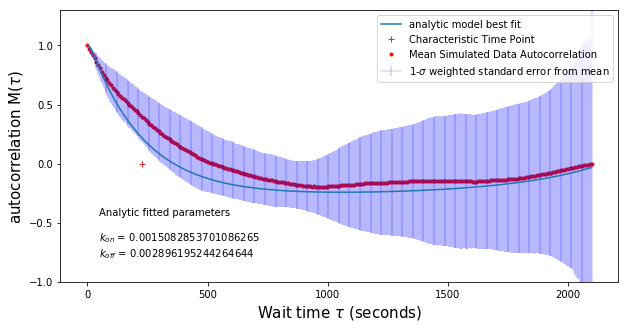

In [49]:
kon_fit,koff_fit,chrtime,pon,popt,pcov = fitAutoPack.leastSquaresAutoFit(printvals=True, upperbound=0.1,lowerbound=0.001, fitpon=True)

In [21]:
# get our data's average autocorrelation function
t = np.arange(len(autoav))

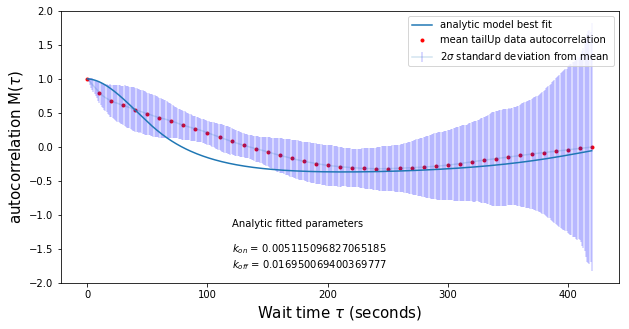

In [22]:
fig,ax = plt.subplots(1, 1, figsize=(10,5), sharex=True)

ax.plot(t, fitAutoPack.autocorrAnalytic(t,1/chrtime), label='analytic model best fit')
#for i in autolist[1:]:
    #plt.plot(t, i[1:], color='b', alpha=0.1)

ax.scatter(t[::10],autoav[::10], marker='.', 
                   color='r', label = 'mean tailUp data autocorrelation')   # show the mean of our original dataset in red
#plt.plot(np.arange(len(autoav)),dat, color='r', label = 'mean data autocorrelation')   # show the mean of our original dataset in red
ax.errorbar(x=t, y=autoav, yerr=(weightedstd*3, weightedstd*3), 
                        ecolor='b', alpha=0.2, label = r'2$\sigma$ standard deviation from mean')  

#plt.plot(chrtime, 1/(np.e), size=20, color='r')
plt.legend(loc="best")
ax.set_ylim(-2, 2)
ax.set_xlabel(r'Wait time $\tau$ (seconds)', fontsize=15)
ax.set_ylabel(r'autocorrelation M($\tau$)', fontsize=15)
#plt.text(x=0.07, y=-1.8, 
             #s='Simulated Parameters \n\n$k_{on}$ =' + str(k_on) +
                    # '\n$k_{off}$ = ' + str(k_off) +  '\n$k_{elong}$ = '+ str(k_elong) 
                             #+ ' bp/sec \nobservation time = '+ str(stepsize) + ' seconds')
plt.text(x=120, y=-1.8, s='Analytic fitted parameters \n\n$k_{on}$ = ' 
                                 + str(kon_fit) + '\n$k_{off}$ = ' + str(koff_fit))
plt.show()

In [26]:
# do a bootstrap on data traces and get range for kon, koff
        # let's get an idea of the spread of our data by using the bootstrap method
        # create a routine that bootstrap fits a set of data arrays
        
tracearray = np.asarray(datatracelist)
n_traces = len(datatracelist)                # number of traces in our dataset
n_trials = 100                      # how many times we wish to compute the bootstrap loop
trace_indx = np.arange(n_traces)      # the index range of the list of traces
auto_averages = []                    # list of averaged autocorrelation functions (should be n_trials long)


# sample randomly, with replacement, a new set of n_traces 10,000 times
for i in range(n_trials):

    # from our list of traces, sample radomly the trace_index of these datum in the list
    random_indx = np.random.choice(trace_indx, size=n_traces, replace=True)  
    # then use this array of indices to create our random distribution of traces
    sample_set = (tracearray[random_indx]).tolist()      # put back into list form
    kon_arr = []
    koff_arr = []
    chrtime_arr = []
    
    
    # with the new sample set, re-compute the average autocorrelation function and perform the inference.
    autopackage = tracePackageAutocorrelation(sample_set, loop_function, start_index, stop_index)
    fitAutoPack = fitAutocorrelationFunction(autopackage, tPol, k_elong, stepsize)
    kon_fit,koff_fit,chrtime,pon,popt,pcov,weightstd = fitAutoPack.leastSquaresAutoFit(printvals=False, upperbound=0.1, lowerbound=0.001)
        
    kon_arr.append(kon_fit)
    koff_arr.append(koff_fit)
    chrtime_arr.append(chrtime)
        
        




([0.001], [0.1])
([0.001], [0.1])
([0.001], [0.1])
([0.001], [0.1])


KeyboardInterrupt: 

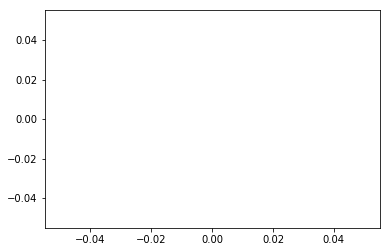

In [27]:
plt.plot(kon_arr, koff_arr)

In [29]:
koff_arr

[]